Librerías necesarias:

In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import csv
#from scipy import stats
#KERAS
import h5py
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from sklearn.metrics import classification_report
import collections
#np.set_printoptions(threshold=np.inf)
from keras.models import model_from_json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from PIL import Image
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
import timeit

Leemos el directorio y contamos cuántas imágenes hay

In [2]:
directoris = []
contador = []
fitxers = []
path_img = []

#Devuelve el path a las imágenes (path_img), el nombre de las imágenes (fitxers) y la cantidad (contador)
for dirname, _, filenames in os.walk('/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train_images',followlinks=False):
    directoris.append(os.path.join(dirname))
    for i in filenames:
        if not '._' in i:
            fitxers.append(i)
            path_img.append(dirname+"/"+i)
    contador.append(dirname+': CONTÉ '+str(len(fitxers)) + ' FOTOS')

In [3]:
# Cargamos el train.csv
csv_train = open('/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train.csv')
csvreader = csv.reader(csv_train)
rows = []
for row in csvreader:
        rows.append(row)

Creamos los sets de imágens y etiquetas

In [4]:
data = []
labels = []
# recorremos los paths de las imágenes y de las filas del csv, buscamos el nombre de la imágen en el
#csv y creamos dos sets de datos con las imágenes y la etiqueta correspondiente en la misma posición
for imagePath in path_img:
    #print(imagePath)
    if not '._' in imagePath:
        for row in rows:
            item = imagePath.split(os.path.sep)[-1]
            if item[0:item.find('.')] in row[0] and item[1]!='_' :
                # leemos la imagen
                image = cv2.imread(imagePath)
                image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
                # creamos los arrays de imágenes y etiquetas
                data.append(image)
                labels.append(row[0][(row[0].find(';'))+1:])

Procesamos las imágenes recortando los bordes y aplicando filtro gausiano

In [5]:
#Función que recorta los bordes de las imágenes 
def crop_border(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray_img > 7       
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
        return img
    else:
        img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
        img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
        img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        img = np.stack([img1,img2,img3],axis=-1)
    return img

In [6]:
processed_data = []
for img in data:
    image = img
    # Cortamos los bordes
    image = crop_border(image)
    image = cv2.resize(image, (256, 256))
    # Aplicamos GaussianBlur
    blurred = cv2.blur(image, ksize=(int(256 / 6), int(256 / 6)))
    image_blur = cv2.addWeighted(image, 4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
    processed_data.append(image_blur)

Balanceamos los datos

In [7]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


{'0': 1796, '1': 369, '2': 995, '3': 193, '4': 295}

In [8]:
minimo=min(counts)
print("Minimo support: ", minimo) #cogemos el minimo para equiparar la data de cada label

Minimo support:  193


In [9]:
fondo=0; necrotico=0; granulado=0; piel=0; esfacelo=0
indices_c=[]; indices_u=[]; indices_d=[]; indices_t=[]; indices_q=[]


In [10]:
lab_0=0; lab_1=0; lab_2=0; lab_3=0; lab_4=0
ind_0=[]; ind_1=[]; ind_2=[]; ind_3=[]; ind_4=[]

for a in range(len(labels)): #hacemos cinco listas de los indices de cada label de longitud=minimo
    if (labels[a]=='0' and lab_0<minimo):
        lab_0+=1
        ind_0.append(a)
    if (labels[a]=='1' and lab_1<minimo):
        lab_1+=1
        ind_1.append(a)
    if (labels[a]=='2' and lab_2<minimo):
        lab_2+=1
        ind_2.append(a)
    if (labels[a]=='3' and lab_3<minimo):
        lab_3+=1
        ind_3.append(a)
    if (labels[a]=='4' and lab_4<minimo):
        lab_4+=1
        ind_4.append(a)

Creamos los conjuntos de entrenamiento, validación y prueba

In [11]:
data_arr = np.array(processed_data)
labels_arr = np.array(labels)

final = int(minimo*0.8)

#se separa la data en train y test
ind_Train = ind_0[:final] + ind_1[:final] + ind_2[:final] + ind_3[:final] + ind_4[:final] 
ind_Test =  ind_0[final:] + ind_1[final:] + ind_2[final:] + ind_3[final:] + ind_4[final:]

print("Lista train:", len(ind_Train)," test: ", len(ind_Test),"\nTotal lista: ", len(ind_Train)+len(ind_Test), " minimo total:", minimo*5)

Train = ind_Train + ind_Test

Train_Data = data_arr[Train, :, :, :] #Todos los datos (train + test)
Train_Labels = to_categorical(np.array(labels_arr[Train])) #Todos las etiquetas (train + test)

indTrainP = np.random.permutation(ind_Train)
indTestP = np.random.permutation(ind_Test) 
 
       
train_data = data_arr[indTrainP, :, :, :] #Datos con el 80% de los datos (train)
print(type(train_data))
print(np.shape(train_data))
train_labels = to_categorical(np.array(labels_arr[indTrainP])) 
print(type(train_labels))
print(np.shape(train_labels))
test_data = data_arr[indTestP, :, :, :] #Datos con el 20% de los datos (test)
test_labels = to_categorical(np.array(labels_arr[indTestP])) #etiquetas de test codificadas (x,5)
print("Shape of labels", train_labels.shape, "shape of data train", train_data.shape, "shape of test train", test_data.shape)

Lista train: 770  test:  195 
Total lista:  965  minimo total: 965
<class 'numpy.ndarray'>
(770, 256, 256, 3)
<class 'numpy.ndarray'>
(770, 5)
Shape of labels (770, 5) shape of data train (770, 256, 256, 3) shape of test train (195, 256, 256, 3)


In [12]:
#PARA COMPROBAR QUE EL NUMERO ES EL MISMO
counterT=collections.Counter(np.argmax(test_labels,axis=1))
print("counter test", counterT)

counterTR=collections.Counter(np.argmax(train_labels,axis=1))
print("counter train", counterTR)

counter test Counter({1: 39, 4: 39, 3: 39, 2: 39, 0: 39})
counter train Counter({3: 154, 1: 154, 0: 154, 4: 154, 2: 154})


Creamos el modelo y entrenamos. El entrenamiento se hace con un optimizador Adam y con un ratio de aprendizaje del 0.001, ya que se ha observado que es el que da mejores resultados. En cuanto al tamaño del batch, se busca cuál es el óptimo a nivel de tiempo y de accuracy. 

In [13]:
# Modelo en red preentrenada
base_model = InceptionV3(input_shape = (256, 256, 3), # El tamaño de nuestras imágenes
include_top = False, # Quitamos la última capa totalmente conectada
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

# Aplanamos la capa de salida del modelo a una sola dimension
x = layers.Flatten()(base_model.output)

# Añadimos una capa totalmente conectada con 1024 neuronas y una activación ReLU
x = layers.Dense(1024, activation='relu')(x)

# Añadimos una dropout de 0.5
x = layers.Dropout(0.5)(x)

# Añadimos una capa densa con una activación softmax para que de un vector de probabilidades en la salida por cada clase
x = layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

2022-05-04 17:43:35.391259: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
#Obtenemos el conjunto de validación con un 10% del de entrenamiento
t_x, val_x, t_y, val_y = train_test_split(train_data, train_labels, test_size=0.1, 
                                           random_state = np.random.randint(1,1000, 1)[0])

def modelLrOpt(opt, lrate, batch_s):
    acc = []
    t = [] 
    # Definimos el criterio de early stopping
    pat = 5 # Este es el número de épocas sin mejora después de las cuales el entrenamiento parará
    early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)
    for bsize in batch_s:
        model.compile(loss='categorical_crossentropy', optimizer=opt(lr=lrate), metrics=['accuracy'])
        start_time = timeit.default_timer()
        history = model.fit(t_x, t_y,validation_data=(val_x, val_y),epochs=20, batch_size=bsize, verbose=1, 
                            callbacks=[early_stopping])
        t.append(timeit.default_timer() - start_time)
        acc.append(model.evaluate(test_data, test_labels, verbose=0)[1])

    return history, model, t, acc

In [23]:
# Entrenamos con varios tamaños de batch y con el optimizador Adam con un learning rate de 0.001
batch = [20,50,100,200]
print("Training Adam models...")
histAdam, modAdam, tAdam, accAdam = modelLrOpt(Adam, 0.001, batch)

Training Adam models...
Epoch 1/20


/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-05-04 19:25:08.458160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


35/35 [==============================] - 109s 3s/step - loss: 117.3717 - accuracy: 0.3838 - val_loss: 42.1236 - val_accuracy: 0.4286
Epoch 2/20
35/35 [==============================] - 110s 3s/step - loss: 22.3688 - accuracy: 0.6205 - val_loss: 13.8224 - val_accuracy: 0.4935
Epoch 3/20
35/35 [==============================] - 112s 3s/step - loss: 5.3742 - accuracy: 0.7273 - val_loss: 8.5172 - val_accuracy: 0.4805
Epoch 4/20
35/35 [==============================] - 112s 3s/step - loss: 2.5261 - accuracy: 0.7706 - val_loss: 6.0132 - val_accuracy: 0.4156
Epoch 5/20
35/35 [==============================] - 113s 3s/step - loss: 1.6325 - accuracy: 0.7864 - val_loss: 3.8263 - val_accuracy: 0.5584
Epoch 6/20
35/35 [==============================] - 2054s 60s/step - loss: 1.0047 - accuracy: 0.8052 - val_loss: 4.6919 - val_accuracy: 0.5195
Epoch 7/20
35/35 [==============================] - 109s 3s/step - loss: 0.8713 - accuracy: 0.8167 - val_loss: 2.9090 - val_accuracy: 0.5065
Epoch 8/20
35/35 

Mostramos las gráficas de tiempo y de accuracy en función de los tamaños del batch utilizados

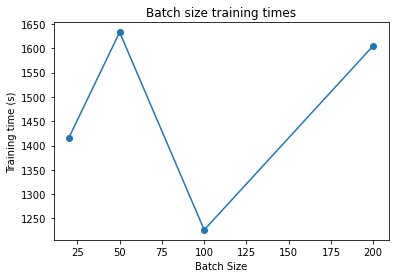

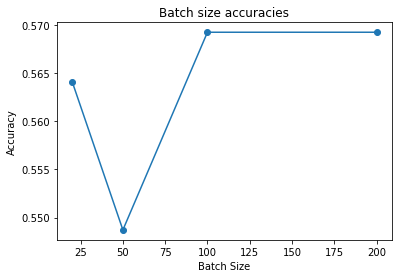

In [26]:
plt.plot(batch, tAdam, marker="o")
plt.title('Batch size training times')
plt.ylabel('Training time (s)')
plt.xlabel('Batch Size')
plt.show()

plt.plot(batch, accAdam, marker="o")
plt.title('Batch size accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Batch Size')
plt.show()